<a href="https://colab.research.google.com/github/wonjinyoo/2024-AI-course/blob/main/AI_assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2024-1 Artificial Intelligence (01)
## Homework #3: Sentiment Analysis with Transformer
---

### Importing necessary libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

### Define multi-head attention block

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        self.ff_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.ff = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        ### Please fill here
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)

        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.ff_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        ### Please fill here

        # Linear layers
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # Scaled dot-product attention
        scaled_attention, attention_weights = self.scaled_dot_product_attention(query, key, value)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # Concatenate heads
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))

        # Final linear layer
        outputs = self.ff(concat_attention)

        return outputs

### Define transformer block

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        ### Please fill here

        # Multi-head attention and dropout 1
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)

        # Residual connection and layer normalization 1
        out1 = self.layernorm1(inputs + attn_output)

        # Feed-forward network
        ffn_output = self.ffn(out1)

        # Dropout 2 and residual connection and layer normalization 2
        ffn_output = self.dropout2(ffn_output, training=training)
        output = self.layernorm2(out1 + ffn_output)

        return output

### Define token and position embedding

In [ ]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

### Dataset preparation

In [ ]:
vocab_size = 20000
max_len = 200

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)
print('Train review size : {}'.format(len(X_train)))
print('Test review size : {}'.format(len(X_test)))

Train review size : 25000
Test review size : 25000


### Pad sequences

In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### Define the whole model
The model looks like this:

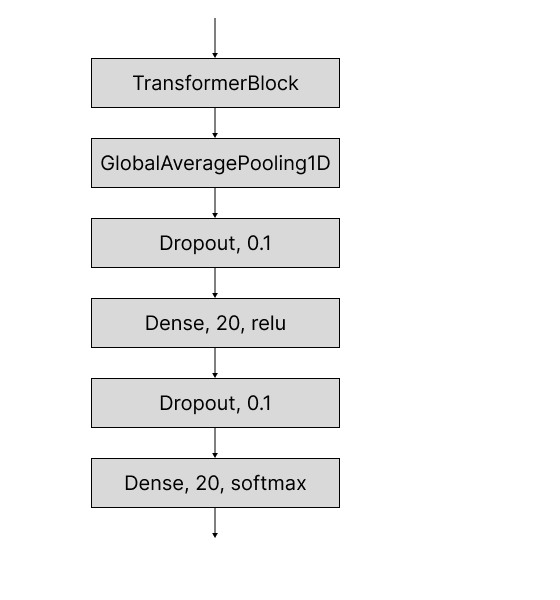

In [ ]:
def Transformer(embedding_dim, num_heads, dff):
  inputs = tf.keras.layers.Input(shape=(max_len,))
  embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
  x = embedding_layer(inputs)
  ### Please fill here

  transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
  x = transformer_block(x)

  x = tf.keras.layers.GlobalAveragePooling1D()(x)
  x = tf.keras.layers.Dropout(0.1)(x)
  x = tf.keras.layers.Dense(20, activation="relu")(x)
  x = tf.keras.layers.Dropout(0.1)(x)
  outputs = tf.keras.layers.Dense(20, activation="softmax")(x)

  return tf.keras.Model(inputs=inputs, outputs=outputs)

### Instantiate model

In [ ]:
embedding_dim = 32  # Embedding vector dim
num_heads = 2
dff = 32  # hidden units of FCN

model = Transformer(embedding_dim, num_heads, dff)

### Complile and train

In [ ]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=32, epochs=2, validation_data=(X_test, y_test))

print("Test accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/2
782/782 [==============================] - 59s 68ms/step - loss: 0.4604 - accuracy: 0.7857 - val_loss: 0.3172 - val_accuracy: 0.8628
Epoch 2/2
782/782 [==============================] - 4s 6ms/step - loss: 0.3104 - accuracy: 0.8739
Test accuracy: 0.8739


### Predict

In [ ]:
word_to_index = imdb.get_word_index()
def sentiment_predict(model, new_sentence):
  new_sentence = re.sub('[^0-9a-zA-Z ]', '', new_sentence).lower()
  encoded = []

  for word in new_sentence.split():
    try :
      if word_to_index[word] <= 10000:
        encoded.append(word_to_index[word]+3)
      else:
        encoded.append(2)
    except KeyError:
      encoded.append(2)

  pad_sequence = pad_sequences([encoded], maxlen=max_len)
  score = float(model.predict(pad_sequence)[0][0])

  if(score > 0.5):
    print("{:.2f}% negative".format(score * 100))
  else:
    print("{:.2f}% positive".format((1 - score) * 100))

text = "This movie was just way too overrated. \
        The fighting was not professional and in slow motion. \
        I was expecting more from a 200 million budget movie. \
        The little sister of T.Challa was just trying too hard to be funny. \
        The story was really dumb as well. \
        Don't watch this movie if you are going because others say its great \
        unless you are a Black Panther fan or Marvels fan."
sentiment_predict(model, text)

1/1 [==============================] - 0s 438ms/step
89.53% negative
